In [1]:
import requests
import json
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import re
from sklearn.preprocessing import MultiLabelBinarizer
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import r2_score, mean_squared_error, confusion_matrix
import matplotlib.pyplot as plt
pd.set_option('display.max_columns',500)

In [2]:
# Compiling links for NBA stats tables
link_dict = {
    'team_game': 'https://stats.nba.com/stats/leaguedashteamstats?Conference=&DateFrom=&DateTo=&Division=&GameScope=&GameSegment=&LastNGames=0&LeagueID=00&Location=&MeasureType=Base&Month=0&OpponentTeamID=0&Outcome=&PORound=0&PaceAdjust=N&PerMode=PerGame&Period=0&PlayerExperience=&PlayerPosition=&PlusMinus=N&Rank=N&SeasonSegment=&SeasonType=Regular+Season&ShotClockRange=&StarterBench=&TeamID=0&TwoWay=0&VsConference=&VsDivision=',
    'player_game': 'https://stats.nba.com/stats/leaguedashplayerstats?College=&Conference=&Country=&DateFrom=&DateTo=&Division=&DraftPick=&DraftYear=&GameScope=&GameSegment=&Height=&LastNGames=0&LeagueID=00&Location=&MeasureType=Base&Month=0&OpponentTeamID=0&Outcome=&PORound=0&PaceAdjust=N&PerMode=PerGame&Period=0&PlayerExperience=&PlayerPosition=&PlusMinus=N&Rank=N&SeasonSegment=&SeasonType=Regular+Season&ShotClockRange=&StarterBench=&TeamID=0&TwoWay=0&VsConference=&VsDivision=&Weight=',
    'player_hustle': 'https://stats.nba.com/stats/leaguehustlestatsplayer?College=&Conference=&Country=&DateFrom=&DateTo=&Division=&DraftPick=&DraftYear=&GameScope=&Height=&LastNGames=0&LeagueID=00&Location=&Month=0&OpponentTeamID=0&Outcome=&PORound=0&PaceAdjust=N&PerMode=PerGame&PlayerExperience=&PlayerPosition=&PlusMinus=N&Rank=N&SeasonSegment=&SeasonType=Regular+Season&TeamID=0&VsConference=&VsDivision=&Weight=',
    'player_general': 'https://stats.nba.com/stats/playerindex?LeagueID=00'
}

In [3]:
# Headers for querying NBA JSON data api
headers  = {
    'Connection': 'keep-alive',
    'Accept': 'application/json, text/plain, */*',
    'x-nba-stats-token': 'true',
    'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/79.0.3945.130 Safari/537.36',
    'x-nba-stats-origin': 'stats',
    'Sec-Fetch-Site': 'same-origin',
    'Sec-Fetch-Mode': 'cors',
    'Referer': 'https://stats.nba.com/',
    'Accept-Encoding': 'gzip, deflate, br',
    'Accept-Language': 'en-US,en;q=0.9',
}

In [4]:
params = {'season':'2021-22', '&SeasonType':'Regular+Season'}

In [5]:
r = requests.get(url = link_dict['player_general'],headers=headers,params=params).json()
player_general = pd.DataFrame(r['resultSets'][0]['rowSet'],columns=r['resultSets'][0]['headers'])
player_general = player_general[['PERSON_ID','POSITION','HEIGHT','WEIGHT','DRAFT_YEAR','FROM_YEAR','TO_YEAR']]
player_general['SEASON'] = params['season']
player_general.rename({'PERSON_ID':'PLAYER_ID'},axis=1,inplace=True)
player_general

,PLAYER_ID,POSITION,HEIGHT,WEIGHT,DRAFT_YEAR,FROM_YEAR,TO_YEAR,SEASON
0,1630173,F,6-8,225,2020.0,2020,2021,2021-22
1,203500,C,6-11,265,2013.0,2013,2021,2021-22
2,1628389,C-F,6-9,255,2017.0,2017,2021,2021-22
3,1630583,F-C,6-11,215,2021.0,2021,2021,2021-22
4,200746,C-F,6-11,250,2006.0,2006,2021,2021-22
...,...,...,...,...,...,...,...,...
613,201152,F,6-8,235,2007.0,2007,2021,2021-22
614,1629027,G,6-1,164,2018.0,2018,2021,2021-22
615,1630209,C,6-11,275,NaN,2020,2021,2021-22
616,203469,F-C,6-11,240,2013.0,2013,2021,2021-22


In [6]:
min_games = 40
min_minutes = 15
drop_cols = ['_RANK','_FANTASY','CFPARA','CFID','TD3','DD2','TEAM_ABBREVIATION','_NAME']
r = requests.get(url = link_dict['player_game'],headers=headers,params=params).json()
player_game = pd.DataFrame(r['resultSets'][0]['rowSet'],columns=r['resultSets'][0]['headers'])
player_game['FTMissed']=player_game['FTA']-player_game['FTM']
player_game['FGMissed']=player_game['FGA']-player_game['FGM']
player_game['FG2M']=player_game['FGM']-player_game['FG3M']
player_game['SEASON'] = params['season']
player_game.drop([col for col in player_game.columns
    if re.search(r"(?=("+'|'.join(drop_cols)+r"))", col)],axis=1,inplace=True) # drop matching columns
player_game = player_game[(player_game['GP']>=min_games)\
            &(player_game['MIN']>=min_minutes)] # only keep players with enough games and minutes per game
player_game

,PLAYER_ID,NICKNAME,TEAM_ID,AGE,GP,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,FTMissed,FGMissed,FG2M,SEASON
0,203932,Aaron,1610612743,26.0,75,46,29,0.613,31.7,5.8,11.1,0.520,1.2,3.5,0.335,2.3,3.1,0.743,1.7,4.2,5.9,2.5,1.8,0.6,0.6,0.7,2.0,2.7,15.0,4.3,0.8,5.3,4.6,2021-22
2,1628988,Aaron,1610612756,25.0,63,34,29,0.540,16.2,2.4,5.4,0.447,0.6,1.6,0.379,0.9,1.1,0.868,0.4,1.6,1.9,2.4,1.1,0.7,0.1,0.3,1.5,1.2,6.3,-0.6,0.2,3.0,1.8,2021-22
4,1630598,Aaron,1610612760,23.0,50,13,37,0.260,24.2,3.1,6.7,0.463,0.8,2.8,0.304,1.2,1.7,0.729,1.0,2.5,3.6,1.4,1.1,0.6,0.2,0.4,1.9,1.3,8.3,-4.7,0.5,3.6,2.3,2021-22
9,201143,Al,1610612738,35.0,69,46,23,0.667,29.1,3.9,8.2,0.467,1.3,3.8,0.336,1.2,1.4,0.842,1.6,6.1,7.7,3.4,0.9,0.7,1.3,0.2,1.9,1.2,10.2,5.6,0.2,4.3,2.6,2021-22
10,202692,Alec,1610612752,30.0,81,37,44,0.457,28.6,3.5,9.0,0.391,1.9,4.8,0.404,2.7,3.3,0.822,0.6,4.3,4.9,3.0,1.1,1.0,0.3,0.3,2.7,3.0,11.7,1.5,0.6,5.5,1.6,2021-22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
591,203115,Will,1610612743,31.0,71,41,30,0.577,32.1,5.5,12.6,0.438,2.2,6.1,0.365,1.4,1.8,0.803,0.6,4.2,4.8,3.9,1.8,0.8,0.4,0.7,1.6,1.8,14.7,1.4,0.4,7.1,3.3,2021-22
593,1626195,Willy,1610612740,27.0,50,22,28,0.440,16.8,3.4,6.5,0.520,0.1,0.2,0.333,2.2,2.8,0.773,2.9,3.9,6.8,1.3,1.0,0.4,0.4,0.5,1.9,2.1,9.1,-0.9,0.6,3.1,3.3,2021-22
600,203897,Zach,1610612741,27.0,67,37,30,0.552,34.7,8.4,17.7,0.476,2.8,7.1,0.389,4.8,5.6,0.853,0.3,4.3,4.6,4.5,2.6,0.6,0.3,0.9,1.8,4.0,24.4,-0.4,0.8,9.3,5.6,2021-22
602,1630192,Zeke,1610612743,21.0,41,24,17,0.585,17.0,2.3,4.5,0.516,0.9,2.0,0.463,1.0,1.6,0.631,1.4,2.2,3.6,0.4,0.6,0.4,0.3,0.5,1.9,1.3,6.6,-1.1,0.6,2.2,1.4,2021-22


In [7]:
player_general = player_general.merge(
        player_game,
    how='inner',on=['PLAYER_ID','SEASON'])
player_general

,PLAYER_ID,POSITION,HEIGHT,WEIGHT,DRAFT_YEAR,FROM_YEAR,TO_YEAR,SEASON,NICKNAME,TEAM_ID,AGE,GP,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,FTMissed,FGMissed,FG2M
0,1630173,F,6-8,225,2020.0,2020,2021,2021-22,Precious,1610612761,22.0,73,46,27,0.630,23.6,3.6,8.3,0.439,0.8,2.1,0.359,1.1,1.8,0.595,2.0,4.5,6.5,1.1,1.2,0.5,0.6,0.7,2.1,1.5,9.1,1.0,0.7,4.7,2.8
1,203500,C,6-11,265,2013.0,2013,2021,2021-22,Steven,1610612763,28.0,76,51,25,0.671,26.3,2.8,5.1,0.547,0.0,0.0,0.000,1.4,2.6,0.543,4.6,5.4,10.0,3.4,1.5,0.9,0.8,0.6,2.0,2.6,6.9,4.6,1.2,2.3,2.8
2,1628389,C-F,6-9,255,2017.0,2017,2021,2021-22,Bam,1610612748,24.0,56,36,20,0.643,32.6,7.3,13.0,0.557,0.0,0.1,0.000,4.6,6.1,0.753,2.4,7.6,10.1,3.4,2.6,1.4,0.8,0.7,3.1,5.4,19.1,5.4,1.5,5.7,7.3
3,200746,C-F,6-11,250,2006.0,2006,2021,2021-22,LaMarcus,1610612751,36.0,47,26,21,0.553,22.3,5.4,9.7,0.550,0.3,1.0,0.304,1.9,2.2,0.873,1.6,3.9,5.5,0.9,0.9,0.3,1.0,0.2,1.7,1.9,12.9,0.4,0.3,4.3,5.1
4,1629638,G,6-5,205,2019.0,2019,2021,2021-22,Nickeil,1610612762,23.0,65,29,36,0.446,22.6,3.9,10.5,0.372,1.6,5.2,0.311,1.2,1.7,0.743,0.6,2.3,2.9,2.4,1.4,0.7,0.4,0.7,1.6,1.5,10.6,-1.7,0.5,6.6,2.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303,1626174,F,6-9,214,NaN,2015,2021,2021-22,Christian,1610612745,26.0,68,19,49,0.279,30.8,6.5,12.9,0.501,1.9,4.9,0.390,3.0,4.9,0.623,1.6,8.5,10.1,2.3,1.9,0.8,1.0,0.7,2.5,4.6,17.9,-6.0,1.9,6.4,4.6
304,1626153,G,6-5,185,2015.0,2015,2021,2021-22,Delon,1610612737,30.0,77,42,35,0.545,18.9,1.6,3.5,0.454,0.6,1.5,0.379,0.7,0.8,0.857,0.6,2.2,2.9,2.4,0.6,1.2,0.2,0.2,0.7,1.0,4.4,0.8,0.1,1.9,1.0
305,201152,F,6-8,235,2007.0,2007,2021,2021-22,Thaddeus,1610612761,33.0,52,27,25,0.519,16.3,2.7,5.2,0.518,0.3,0.9,0.354,0.4,0.9,0.469,1.5,2.5,4.0,2.0,1.0,1.0,0.3,0.4,1.6,1.0,6.2,0.4,0.5,2.5,2.4
306,1629027,G,6-1,164,2018.0,2018,2021,2021-22,Trae,1610612737,23.0,76,40,36,0.526,34.9,9.4,20.3,0.460,3.1,8.0,0.382,6.6,7.3,0.904,0.7,3.1,3.7,9.7,4.0,0.9,0.1,1.2,1.7,5.9,28.4,2.1,0.7,10.9,6.3


In [8]:
# drop_cols = []
r = requests.get(url = link_dict['player_hustle'],headers=headers,params=params).json()
player_hustle = pd.DataFrame(r['resultSets'][0]['rowSet'],columns=r['resultSets'][0]['headers'])
player_hustle['SEASON'] = params['season']
# player_hustle.drop([col for col in player_hustle.columns
#     if re.search(r"(?=("+'|'.join(drop_cols)+r"))", col)],axis=1,inplace=True)
player_hustle

,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_ABBREVIATION,AGE,G,MIN,CONTESTED_SHOTS,CONTESTED_SHOTS_2PT,CONTESTED_SHOTS_3PT,DEFLECTIONS,CHARGES_DRAWN,SCREEN_ASSISTS,SCREEN_AST_PTS,OFF_LOOSE_BALLS_RECOVERED,DEF_LOOSE_BALLS_RECOVERED,LOOSE_BALLS_RECOVERED,PCT_LOOSE_BALLS_RECOVERED_OFF,PCT_LOOSE_BALLS_RECOVERED_DEF,OFF_BOXOUTS,DEF_BOXOUTS,BOX_OUTS,BOX_OUT_PLAYER_TEAM_REBS,BOX_OUT_PLAYER_REBS,PCT_BOX_OUTS_OFF,PCT_BOX_OUTS_DEF,PCT_BOX_OUTS_TEAM_REB,PCT_BOX_OUTS_REB,SEASON
0,203932,Aaron Gordon,1610612743,DEN,26.0,75,31.7,5.32,3.47,1.85,0.91,0.01,0.71,1.73,0.41,0.25,0.67,0.620,0.380,0.13,0.39,0.52,0.44,0.32,0.256,0.744,0.943,0.686,2021-22
1,1630565,Aaron Henry,1610612755,PHI,22.0,6,2.8,0.83,0.50,0.33,0.17,0.00,0.00,0.00,0.00,0.00,0.00,0.000,0.000,0.00,0.17,0.17,0.00,0.00,0.000,1.000,0.000,0.000,2021-22
2,1628988,Aaron Holiday,1610612756,PHX,25.0,63,16.2,2.63,1.21,1.43,1.32,0.02,0.13,0.33,0.19,0.25,0.44,0.429,0.571,0.03,0.29,0.32,0.30,0.05,0.100,0.900,0.950,0.150,2021-22
3,1630174,Aaron Nesmith,1610612738,BOS,22.0,52,11.0,2.90,1.83,1.08,0.56,0.08,0.08,0.19,0.10,0.15,0.25,0.385,0.615,0.06,0.44,0.50,0.44,0.19,0.115,0.885,0.958,0.417,2021-22
4,1630598,Aaron Wiggins,1610612760,OKC,23.0,50,24.2,6.04,3.06,2.98,1.30,0.00,0.28,0.60,0.20,0.32,0.52,0.385,0.615,0.02,0.46,0.48,0.44,0.18,0.042,0.958,0.957,0.391,2021-22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
600,203897,Zach LaVine,1610612741,CHI,27.0,67,34.7,5.94,2.52,3.42,1.03,0.01,0.45,0.94,0.39,0.24,0.63,0.619,0.381,0.04,0.37,0.42,0.40,0.21,0.107,0.893,0.964,0.500,2021-22
601,1630285,Zavier Simpson,1610612760,OKC,25.0,4,43.5,9.75,3.75,6.00,2.25,0.00,0.00,0.00,0.25,0.75,1.00,0.250,0.750,0.00,0.25,0.25,0.25,0.00,0.000,1.000,1.000,0.000,2021-22
602,1630192,Zeke Nnaji,1610612743,DEN,21.0,41,17.0,3.68,2.00,1.68,0.76,0.00,0.95,2.37,0.24,0.15,0.39,0.625,0.375,0.54,0.73,1.27,1.15,0.76,0.423,0.577,0.979,0.646,2021-22
603,1630533,Ziaire Williams,1610612763,MEM,20.0,62,21.7,4.63,2.15,2.48,0.98,0.00,0.11,0.24,0.13,0.18,0.31,0.421,0.579,0.00,0.23,0.23,0.19,0.05,0.000,1.000,1.000,0.250,2021-22


In [9]:
player_general = player_general.merge(
        player_hustle,
    how='inner',on=['PLAYER_ID','SEASON']).drop('G',axis=1)
drop_cols = ['_x','NICK','TEAM_ID','_y']
player_general.drop([col for col in player_general.columns
    if re.search(r"(?=("+'|'.join(drop_cols)+r"))", col)],axis=1,inplace=True) # drop matching columns
player_general['POSITION2'] = player_general['POSITION'].str.split('-')
player_general = pd.get_dummies(player_general, columns = ['POSITION'])
player_general['HEIGHT'] = player_general['HEIGHT'].str.split('-').str[0].astype(int)*12\
    +player_general['HEIGHT'].str.split('-').str[1].astype(int)
player_general

,PLAYER_ID,HEIGHT,WEIGHT,DRAFT_YEAR,FROM_YEAR,TO_YEAR,SEASON,GP,W,L,W_PCT,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,FTMissed,FGMissed,FG2M,PLAYER_NAME,TEAM_ABBREVIATION,CONTESTED_SHOTS,CONTESTED_SHOTS_2PT,CONTESTED_SHOTS_3PT,DEFLECTIONS,CHARGES_DRAWN,SCREEN_ASSISTS,SCREEN_AST_PTS,OFF_LOOSE_BALLS_RECOVERED,DEF_LOOSE_BALLS_RECOVERED,LOOSE_BALLS_RECOVERED,PCT_LOOSE_BALLS_RECOVERED_OFF,PCT_LOOSE_BALLS_RECOVERED_DEF,OFF_BOXOUTS,DEF_BOXOUTS,BOX_OUTS,BOX_OUT_PLAYER_TEAM_REBS,BOX_OUT_PLAYER_REBS,PCT_BOX_OUTS_OFF,PCT_BOX_OUTS_DEF,PCT_BOX_OUTS_TEAM_REB,PCT_BOX_OUTS_REB,POSITION2,POSITION_C,POSITION_C-F,POSITION_F,POSITION_F-C,POSITION_F-G,POSITION_G,POSITION_G-F
0,1630173,80,225,2020.0,2020,2021,2021-22,73,46,27,0.630,3.6,8.3,0.439,0.8,2.1,0.359,1.1,1.8,0.595,2.0,4.5,6.5,1.1,1.2,0.5,0.6,0.7,2.1,1.5,9.1,1.0,0.7,4.7,2.8,Precious Achiuwa,TOR,7.99,5.48,2.51,1.00,0.05,1.71,4.04,0.29,0.36,0.64,0.447,0.553,0.38,0.97,1.36,1.16,0.66,0.283,0.717,0.924,0.522,[F],0,0,1,0,0,0,0
1,203500,83,265,2013.0,2013,2021,2021-22,76,51,25,0.671,2.8,5.1,0.547,0.0,0.0,0.000,1.4,2.6,0.543,4.6,5.4,10.0,3.4,1.5,0.9,0.8,0.6,2.0,2.6,6.9,4.6,1.2,2.3,2.8,Steven Adams,MEM,9.01,7.07,1.95,1.61,0.03,5.47,12.01,0.57,0.28,0.84,0.672,0.328,1.78,2.04,3.82,3.18,2.04,0.466,0.534,0.949,0.608,[C],1,0,0,0,0,0,0
2,1628389,81,255,2017.0,2017,2021,2021-22,56,36,20,0.643,7.3,13.0,0.557,0.0,0.1,0.000,4.6,6.1,0.753,2.4,7.6,10.1,3.4,2.6,1.4,0.8,0.7,3.1,5.4,19.1,5.4,1.5,5.7,7.3,Bam Adebayo,MIA,7.84,4.93,2.91,2.43,0.05,3.79,9.61,0.54,0.38,0.91,0.588,0.412,0.55,2.68,3.23,2.79,1.59,0.171,0.829,0.969,0.553,"[C, F]",0,1,0,0,0,0,0
3,200746,83,250,2006.0,2006,2021,2021-22,47,26,21,0.553,5.4,9.7,0.550,0.3,1.0,0.304,1.9,2.2,0.873,1.6,3.9,5.5,0.9,0.9,0.3,1.0,0.2,1.7,1.9,12.9,0.4,0.3,4.3,5.1,LaMarcus Aldridge,BKN,8.38,6.36,2.02,0.85,0.00,2.47,5.62,0.21,0.11,0.32,0.667,0.333,0.49,1.62,2.11,1.72,1.13,0.232,0.768,0.920,0.602,"[C, F]",0,1,0,0,0,0,0
4,1629638,77,205,2019.0,2019,2021,2021-22,65,29,36,0.446,3.9,10.5,0.372,1.6,5.2,0.311,1.2,1.7,0.743,0.6,2.3,2.9,2.4,1.4,0.7,0.4,0.7,1.6,1.5,10.6,-1.7,0.5,6.6,2.3,Nickeil Alexander-Walker,UTA,3.09,1.83,1.26,1.66,0.03,0.17,0.37,0.23,0.25,0.48,0.484,0.516,0.06,0.32,0.38,0.32,0.11,0.160,0.840,0.955,0.318,[G],0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303,1626174,81,214,NaN,2015,2021,2021-22,68,19,49,0.279,6.5,12.9,0.501,1.9,4.9,0.390,3.0,4.9,0.623,1.6,8.5,10.1,2.3,1.9,0.8,1.0,0.7,2.5,4.6,17.9,-6.0,1.9,6.4,4.6,Christian Wood,HOU,10.54,6.54,4.00,1.24,0.00,1.88,4.54,0.22,0.29,0.51,0.429,0.571,0.25,1.18,1.43,1.21,0.72,0.175,0.825,0.976,0.583,[F],0,0,1,0,0,0,0
304,1626153,77,185,2015.0,2015,2021,2021-22,77,42,35,0.545,1.6,3.5,0.454,0.6,1.5,0.379,0.7,0.8,0.857,0.6,2.2,2.9,2.4,0.6,1.2,0.2,0.2,0.7,1.0,4.4,0.8,0.1,1.9,1.0,Delon Wright,ATL,2.77,1.56,1.21,1.94,0.03,0.21,0.44,0.30,0.34,0.64,0.469,0.531,0.04,0.30,0.34,0.29,0.06,0.115,0.885,0.957,0.217,[G],0,0,0,0,0,1,0
305,201152,80,235,2007.0,2007,2021,2021-22,52,27,25,0.519,2.7,5.2,0.518,0.3,0.9,0.354,0.4,0.9,0.469,1.5,2.5,4.0,2.0,1.0,1.0,0.3,0.4,1.6,1.0,6.2,0.4,0.5,2.5,2.4,Thaddeus Young,TOR,4.79,2.60,2.19,1.65,0.21,1.40,3.04,0.31,0.31,0.62,0.500,0.500,0.13,0.88,1.02,0.81,0.38,0.132,0.868,0.955,0.455,[F],0,0,1,0,0,0,0
306,1629027,73,164,2018.0,2018,2021,2021-22,76,40,36,0.526,9.4,20.3,0.460,3.1,8.0,0.382,6.6,7.3,0.904,0.7,3.1,3.7,9.7,4.0,0.9,0.1,1.2,1.7,5.9,28.4,2.1,0.7,10.9,6.3,Trae Young,ATL,2.07,0.75,1.32,1.72,0.08,0.16,0.37,0.43,0.41,0.84,0.516,0.484,0.00,0.13,0.13,0.11,0.03,0.000,1.000,0.889,0.222,[G],0,0,0,0,0,1,0


In [10]:
mlb = MultiLabelBinarizer()
player_general = player_general.merge(pd.DataFrame(mlb.fit_transform(player_general['POSITION2']),columns=mlb.classes_, index=player_general.index),
                     how='inner', left_index=True, right_index=True).drop(['POSITION2'],axis=1)
player_general['TRUE_SHOOTING'] = player_general['PTS']/(0.44*player_general['FTA']+player_general['FGA'])
player_general['FG2A'] = player_general['FGA'] - player_general['FG3A']
player_general['FG2M'] = player_general['FGM'] - player_general['FG3M']
player_general['FG2_PCT'] = player_general['FG2M']/player_general['FG2A']
player_general

,PLAYER_ID,HEIGHT,WEIGHT,DRAFT_YEAR,FROM_YEAR,TO_YEAR,SEASON,GP,W,L,W_PCT,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,FTMissed,FGMissed,FG2M,PLAYER_NAME,TEAM_ABBREVIATION,CONTESTED_SHOTS,CONTESTED_SHOTS_2PT,CONTESTED_SHOTS_3PT,DEFLECTIONS,CHARGES_DRAWN,SCREEN_ASSISTS,SCREEN_AST_PTS,OFF_LOOSE_BALLS_RECOVERED,DEF_LOOSE_BALLS_RECOVERED,LOOSE_BALLS_RECOVERED,PCT_LOOSE_BALLS_RECOVERED_OFF,PCT_LOOSE_BALLS_RECOVERED_DEF,OFF_BOXOUTS,DEF_BOXOUTS,BOX_OUTS,BOX_OUT_PLAYER_TEAM_REBS,BOX_OUT_PLAYER_REBS,PCT_BOX_OUTS_OFF,PCT_BOX_OUTS_DEF,PCT_BOX_OUTS_TEAM_REB,PCT_BOX_OUTS_REB,POSITION_C,POSITION_C-F,POSITION_F,POSITION_F-C,POSITION_F-G,POSITION_G,POSITION_G-F,C,F,G,TRUE_SHOOTING,FG2A,FG2_PCT
0,1630173,80,225,2020.0,2020,2021,2021-22,73,46,27,0.630,3.6,8.3,0.439,0.8,2.1,0.359,1.1,1.8,0.595,2.0,4.5,6.5,1.1,1.2,0.5,0.6,0.7,2.1,1.5,9.1,1.0,0.7,4.7,2.8,Precious Achiuwa,TOR,7.99,5.48,2.51,1.00,0.05,1.71,4.04,0.29,0.36,0.64,0.447,0.553,0.38,0.97,1.36,1.16,0.66,0.283,0.717,0.924,0.522,0,0,1,0,0,0,0,0,1,0,1.000880,6.2,0.451613
1,203500,83,265,2013.0,2013,2021,2021-22,76,51,25,0.671,2.8,5.1,0.547,0.0,0.0,0.000,1.4,2.6,0.543,4.6,5.4,10.0,3.4,1.5,0.9,0.8,0.6,2.0,2.6,6.9,4.6,1.2,2.3,2.8,Steven Adams,MEM,9.01,7.07,1.95,1.61,0.03,5.47,12.01,0.57,0.28,0.84,0.672,0.328,1.78,2.04,3.82,3.18,2.04,0.466,0.534,0.949,0.608,1,0,0,0,0,0,0,1,0,0,1.105061,5.1,0.549020
2,1628389,81,255,2017.0,2017,2021,2021-22,56,36,20,0.643,7.3,13.0,0.557,0.0,0.1,0.000,4.6,6.1,0.753,2.4,7.6,10.1,3.4,2.6,1.4,0.8,0.7,3.1,5.4,19.1,5.4,1.5,5.7,7.3,Bam Adebayo,MIA,7.84,4.93,2.91,2.43,0.05,3.79,9.61,0.54,0.38,0.91,0.588,0.412,0.55,2.68,3.23,2.79,1.59,0.171,0.829,0.969,0.553,0,1,0,0,0,0,0,1,1,0,1.217802,12.9,0.565891
3,200746,83,250,2006.0,2006,2021,2021-22,47,26,21,0.553,5.4,9.7,0.550,0.3,1.0,0.304,1.9,2.2,0.873,1.6,3.9,5.5,0.9,0.9,0.3,1.0,0.2,1.7,1.9,12.9,0.4,0.3,4.3,5.1,LaMarcus Aldridge,BKN,8.38,6.36,2.02,0.85,0.00,2.47,5.62,0.21,0.11,0.32,0.667,0.333,0.49,1.62,2.11,1.72,1.13,0.232,0.768,0.920,0.602,0,1,0,0,0,0,0,1,1,0,1.209224,8.7,0.586207
4,1629638,77,205,2019.0,2019,2021,2021-22,65,29,36,0.446,3.9,10.5,0.372,1.6,5.2,0.311,1.2,1.7,0.743,0.6,2.3,2.9,2.4,1.4,0.7,0.4,0.7,1.6,1.5,10.6,-1.7,0.5,6.6,2.3,Nickeil Alexander-Walker,UTA,3.09,1.83,1.26,1.66,0.03,0.17,0.37,0.23,0.25,0.48,0.484,0.516,0.06,0.32,0.38,0.32,0.11,0.160,0.840,0.955,0.318,0,0,0,0,0,1,0,0,0,1,0.942390,5.3,0.433962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303,1626174,81,214,NaN,2015,2021,2021-22,68,19,49,0.279,6.5,12.9,0.501,1.9,4.9,0.390,3.0,4.9,0.623,1.6,8.5,10.1,2.3,1.9,0.8,1.0,0.7,2.5,4.6,17.9,-6.0,1.9,6.4,4.6,Christian Wood,HOU,10.54,6.54,4.00,1.24,0.00,1.88,4.54,0.22,0.29,0.51,0.429,0.571,0.25,1.18,1.43,1.21,0.72,0.175,0.825,0.976,0.583,0,0,1,0,0,0,0,0,1,0,1.188895,8.0,0.575000
304,1626153,77,185,2015.0,2015,2021,2021-22,77,42,35,0.545,1.6,3.5,0.454,0.6,1.5,0.379,0.7,0.8,0.857,0.6,2.2,2.9,2.4,0.6,1.2,0.2,0.2,0.7,1.0,4.4,0.8,0.1,1.9,1.0,Delon Wright,ATL,2.77,1.56,1.21,1.94,0.03,0.21,0.44,0.30,0.34,0.64,0.469,0.531,0.04,0.30,0.34,0.29,0.06,0.115,0.885,0.957,0.217,0,0,0,0,0,1,0,0,0,1,1.142264,2.0,0.500000
305,201152,80,235,2007.0,2007,2021,2021-22,52,27,25,0.519,2.7,5.2,0.518,0.3,0.9,0.354,0.4,0.9,0.469,1.5,2.5,4.0,2.0,1.0,1.0,0.3,0.4,1.6,1.0,6.2,0.4,0.5,2.5,2.4,Thaddeus Young,TOR,4.79,2.60,2.19,1.65,0.21,1.40,3.04,0.31,0.31,0.62,0.500,0.500,0.13,0.88,1.02,0.81,0.38,0.132,0.868,0.955,0.455,0,0,1,0,0,0,0,0,1,0,1.107934,4.3,0.558140
306,1629027,73,164,2018.0,2018,2021,2021-22,76,40,36,0.526,9.4,20.3,0.460,3.1,8.0,0.382,6.6,7.3,0.904,0.7,3.1,3.7,9.7,4.0,0.9,0.1,1.2,1.7,5.9,28.4,2.1,0.7,10.9,6.3,Trae Young,ATL,2.07,0.75,1.32,1.72,0.08,0.16,0.37,0.43,0.41,0.84,0.516,0.484,0.00,0.13,0.13,0.11,0.03,0.000,1.000,0.889,0.222,0,0,

In [11]:
keep_index = ['PLUS_MINUS']
corr_df = player_general.corr()
corr_df[corr_df.index.isin(keep_index)]

,PLAYER_ID,HEIGHT,DRAFT_YEAR,GP,W,L,W_PCT,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,FTMissed,FGMissed,FG2M,CONTESTED_SHOTS,CONTESTED_SHOTS_2PT,CONTESTED_SHOTS_3PT,DEFLECTIONS,CHARGES_DRAWN,SCREEN_ASSISTS,SCREEN_AST_PTS,OFF_LOOSE_BALLS_RECOVERED,DEF_LOOSE_BALLS_RECOVERED,LOOSE_BALLS_RECOVERED,PCT_LOOSE_BALLS_RECOVERED_OFF,PCT_LOOSE_BALLS_RECOVERED_DEF,OFF_BOXOUTS,DEF_BOXOUTS,BOX_OUTS,BOX_OUT_PLAYER_TEAM_REBS,BOX_OUT_PLAYER_REBS,PCT_BOX_OUTS_OFF,PCT_BOX_OUTS_DEF,PCT_BOX_OUTS_TEAM_REB,PCT_BOX_OUTS_REB,POSITION_C,POSITION_C-F,POSITION_F,POSITION_F-C,POSITION_F-G,POSITION_G,POSITION_G-F,C,F,G,TRUE_SHOOTING,FG2A,FG2_PCT
PLUS_MINUS,-0.138816,0.02343,-0.219351,0.22217,0.767112,-0.668669,0.835944,0.269037,0.205932,0.19456,0.164817,0.123773,0.016979,0.213417,0.190397,0.146024,0.126012,0.227517,0.211724,0.238559,0.148329,0.275891,0.103729,0.047517,0.119995,0.205753,0.268934,1.0,0.067939,0.140063,0.225964,0.156192,0.128889,0.153456,0.199262,0.014123,0.129618,0.134494,0.217155,0.249094,0.265356,-0.034264,0.034217,0.113904,0.192447,0.177404,0.180355,0.160737,0.048728,-0.048789,0.050632,0.008981,0.077923,0.091346,0.007161,-0.057665,-0.003838,-0.03967,-0.019288,0.056641,0.000956,-0.051861,0.314264,0.185528,0.179781


In [12]:
predict_plus_minus = player_general.drop(['W_PCT','PLAYER_ID','DRAFT_YEAR','GP','W','L',
                                          'W_PCT','SEASON','PLAYER_NAME','TEAM_ABBREVIATION',
                                         'FROM_YEAR','TO_YEAR','HEIGHT','WEIGHT'], axis=1)
predict_plus_minus

,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,FTMissed,FGMissed,FG2M,CONTESTED_SHOTS,CONTESTED_SHOTS_2PT,CONTESTED_SHOTS_3PT,DEFLECTIONS,CHARGES_DRAWN,SCREEN_ASSISTS,SCREEN_AST_PTS,OFF_LOOSE_BALLS_RECOVERED,DEF_LOOSE_BALLS_RECOVERED,LOOSE_BALLS_RECOVERED,PCT_LOOSE_BALLS_RECOVERED_OFF,PCT_LOOSE_BALLS_RECOVERED_DEF,OFF_BOXOUTS,DEF_BOXOUTS,BOX_OUTS,BOX_OUT_PLAYER_TEAM_REBS,BOX_OUT_PLAYER_REBS,PCT_BOX_OUTS_OFF,PCT_BOX_OUTS_DEF,PCT_BOX_OUTS_TEAM_REB,PCT_BOX_OUTS_REB,POSITION_C,POSITION_C-F,POSITION_F,POSITION_F-C,POSITION_F-G,POSITION_G,POSITION_G-F,C,F,G,TRUE_SHOOTING,FG2A,FG2_PCT
0,3.6,8.3,0.439,0.8,2.1,0.359,1.1,1.8,0.595,2.0,4.5,6.5,1.1,1.2,0.5,0.6,0.7,2.1,1.5,9.1,1.0,0.7,4.7,2.8,7.99,5.48,2.51,1.00,0.05,1.71,4.04,0.29,0.36,0.64,0.447,0.553,0.38,0.97,1.36,1.16,0.66,0.283,0.717,0.924,0.522,0,0,1,0,0,0,0,0,1,0,1.000880,6.2,0.451613
1,2.8,5.1,0.547,0.0,0.0,0.000,1.4,2.6,0.543,4.6,5.4,10.0,3.4,1.5,0.9,0.8,0.6,2.0,2.6,6.9,4.6,1.2,2.3,2.8,9.01,7.07,1.95,1.61,0.03,5.47,12.01,0.57,0.28,0.84,0.672,0.328,1.78,2.04,3.82,3.18,2.04,0.466,0.534,0.949,0.608,1,0,0,0,0,0,0,1,0,0,1.105061,5.1,0.549020
2,7.3,13.0,0.557,0.0,0.1,0.000,4.6,6.1,0.753,2.4,7.6,10.1,3.4,2.6,1.4,0.8,0.7,3.1,5.4,19.1,5.4,1.5,5.7,7.3,7.84,4.93,2.91,2.43,0.05,3.79,9.61,0.54,0.38,0.91,0.588,0.412,0.55,2.68,3.23,2.79,1.59,0.171,0.829,0.969,0.553,0,1,0,0,0,0,0,1,1,0,1.217802,12.9,0.565891
3,5.4,9.7,0.550,0.3,1.0,0.304,1.9,2.2,0.873,1.6,3.9,5.5,0.9,0.9,0.3,1.0,0.2,1.7,1.9,12.9,0.4,0.3,4.3,5.1,8.38,6.36,2.02,0.85,0.00,2.47,5.62,0.21,0.11,0.32,0.667,0.333,0.49,1.62,2.11,1.72,1.13,0.232,0.768,0.920,0.602,0,1,0,0,0,0,0,1,1,0,1.209224,8.7,0.586207
4,3.9,10.5,0.372,1.6,5.2,0.311,1.2,1.7,0.743,0.6,2.3,2.9,2.4,1.4,0.7,0.4,0.7,1.6,1.5,10.6,-1.7,0.5,6.6,2.3,3.09,1.83,1.26,1.66,0.03,0.17,0.37,0.23,0.25,0.48,0.484,0.516,0.06,0.32,0.38,0.32,0.11,0.160,0.840,0.955,0.318,0,0,0,0,0,1,0,0,0,1,0.942390,5.3,0.433962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303,6.5,12.9,0.501,1.9,4.9,0.390,3.0,4.9,0.623,1.6,8.5,10.1,2.3,1.9,0.8,1.0,0.7,2.5,4.6,17.9,-6.0,1.9,6.4,4.6,10.54,6.54,4.00,1.24,0.00,1.88,4.54,0.22,0.29,0.51,0.429,0.571,0.25,1.18,1.43,1.21,0.72,0.175,0.825,0.976,0.583,0,0,1,0,0,0,0,0,1,0,1.188895,8.0,0.575000
304,1.6,3.5,0.454,0.6,1.5,0.379,0.7,0.8,0.857,0.6,2.2,2.9,2.4,0.6,1.2,0.2,0.2,0.7,1.0,4.4,0.8,0.1,1.9,1.0,2.77,1.56,1.21,1.94,0.03,0.21,0.44,0.30,0.34,0.64,0.469,0.531,0.04,0.30,0.34,0.29,0.06,0.115,0.885,0.957,0.217,0,0,0,0,0,1,0,0,0,1,1.142264,2.0,0.500000
305,2.7,5.2,0.518,0.3,0.9,0.354,0.4,0.9,0.469,1.5,2.5,4.0,2.0,1.0,1.0,0.3,0.4,1.6,1.0,6.2,0.4,0.5,2.5,2.4,4.79,2.60,2.19,1.65,0.21,1.40,3.04,0.31,0.31,0.62,0.500,0.500,0.13,0.88,1.02,0.81,0.38,0.132,0.868,0.955,0.455,0,0,1,0,0,0,0,0,1,0,1.107934,4.3,0.558140
306,9.4,20.3,0.460,3.1,8.0,0.382,6.6,7.3,0.904,0.7,3.1,3.7,9.7,4.0,0.9,0.1,1.2,1.7,5.9,28.4,2.1,0.7,10.9,6.3,2.07,0.75,1.32,1.72,0.08,0.16,0.37,0.43,0.41,0.84,0.516,0.484,0.00,0.13,0.13,0.11,0.03,0.000,1.000,0.889,0.222,0,0,0,0,0,1,0,0,0,1,1.207894,12.3,0.512195


In [13]:
# ToDo
# Make a function for each major processing step
    # Make a combined function
# Try a deep learning model even though sparse points.
# If not enough, get multiple years of data

In [14]:
# # Saving time for salary with code from here: https://medium.com/swlh/linking-nba-salary-to-performance-sample-player-analysis-with-python-2c568455b306
# r = requests.get('https://hoopshype.com/salaries/')
# r_html = r.text

# soup = BeautifulSoup(r_html, 'html.parser')

# salary_table = soup.find('table')
# length=len(salary_table.find_all("td"))

# player_names=[salary_table.find_all("td")[i].text.strip() for i in range(9,length,8)]

# column1=[salary_table.find_all("td")[i].text.strip() for i in range(10,length,8)]
# column2=[salary_table.find_all("td")[i].text.strip() for i in range(11,length,8)]
# column3=[salary_table.find_all("td")[i].text.strip() for i in range(12,length,8)]
# column4=[salary_table.find_all("td")[i].text.strip() for i in range(13,length,8)]
# column5=[salary_table.find_all("td")[i].text.strip() for i in range(14,length,8)]
# column6=[salary_table.find_all("td")[i].text.strip() for i in range(15,length,8)]
# df_dict={'player_names':player_names,
#         '2019/20':column1,
#         '2020/21':column2,
#         '2021/22':column3,
#         '2022/23':column4,
#         '2023/24':column5,
#         '2024/25':column6}
        
# salary_df = pd.DataFrame(df_dict)
# salary_df

In [15]:
def train_test_split_df(df,Y_val,test_size=0.4,random_state=42):
    train_features, test_features = train_test_split(df.dropna(),test_size=test_size,random_state=random_state)
    train_labels = train_features.pop(Y_val)
#     train_labels['Y']=np.where(train_labels.values>0,1,0)
#     train_labels['asd']=np.where(train_labels[Y_val]>0,1,0)
    test_labels = test_features.pop(Y_val)
#     test_labels['asd']=np.where(test_labels[Y_val]>0,1,0)
    return np.asarray(train_features.sort_index()).astype(np.float32),\
        np.asarray(train_labels.sort_index()).astype(np.float32),\
        np.asarray(test_features.sort_index()).astype(np.float32),\
        np.asarray(test_labels.sort_index()).astype(np.float32)

In [61]:
# define a function to create the deep neural network model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
def tf_model(norm):
    col_len = train_features.shape[1]
    model = keras.Sequential([
    norm,
    layers.Dense((col_len), activation='relu', input_dim=col_len),
#     layers.Dense((col_len)*2, activation='relu'),
#     layers.Dense((col_len), activation='relu'),
#     layers.Dense(round((col_len)/2), activation='relu'),
#     layers.Dense(col_len, activation='relu'),
    layers.Dense(1)
                 ])
    model.compile(loss='mean_squared_error', optimizer='adam', #'rmsprop', 
                 metrics = ['mean_squared_error'] )
    return model

In [54]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Dense, Dropout
from keras.models import Sequential
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Ridge, LinearRegression
all_models = {}
y_values = {}
x_values = {}
normalizer = tf.keras.layers.Normalization()
split_nums = [40,600,2432342,4645646,874,9846]
for i in split_nums:
    # Split the data
    train_features, train_labels, test_features, test_labels = train_test_split_df(predict_plus_minus,'PLUS_MINUS',random_state=i)
    # Normalize and run TF model
#     normalizer = tf.keras.layers.Normalization()
    normalizer.adapt(train_features)
    tf = tf_model(normalizer)
    tf.fit(train_features, train_labels, epochs=50, verbose=False)
    # Run Dummy model
    dummy = DummyRegressor(strategy="mean")
    dummy.fit(train_features,train_labels)
    # Run Ridge model
    ridge = Ridge(alpha=1.0)
    ridge.fit(train_features,train_labels)
    # Run Linear model
    lin = LinearRegression()
    lin.fit(train_features,train_labels)
    # Run Decision Tree model
    dtr = tree.DecisionTreeRegressor(max_depth=10)
    dtr.fit(train_features,train_labels)
    all_models[str(i)+'tf'] = tf
    all_models[str(i)+'dummy'] = dummy
    all_models[str(i)+'ridge'] = ridge
    all_models[str(i)+'dtr'] = dtr
    all_models[str(i)+'lin'] = lin
    y_values[i] = test_labels
    x_values[i] = test_features
    print(i)

40
600
2432342
4645646
874
9846


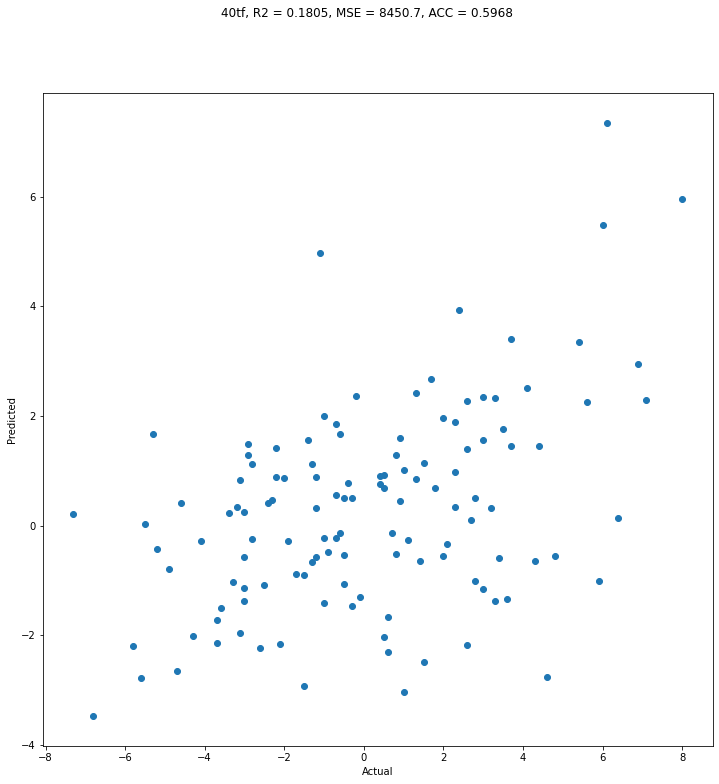

C:\Users\jwesi\AppData\Local\Temp\ipykernel_32640\867298794.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfasd=dfasd.append(pd.DataFrame.from_dict({'Actual':y_values[i],'Pred':preds}))
C:\Users\jwesi\AppData\Local\Temp\ipykernel_32640\867298794.py:11: RuntimeWarning: invalid value encountered in longlong_scalars
  negacc = round(tn/(fn+tn),2)


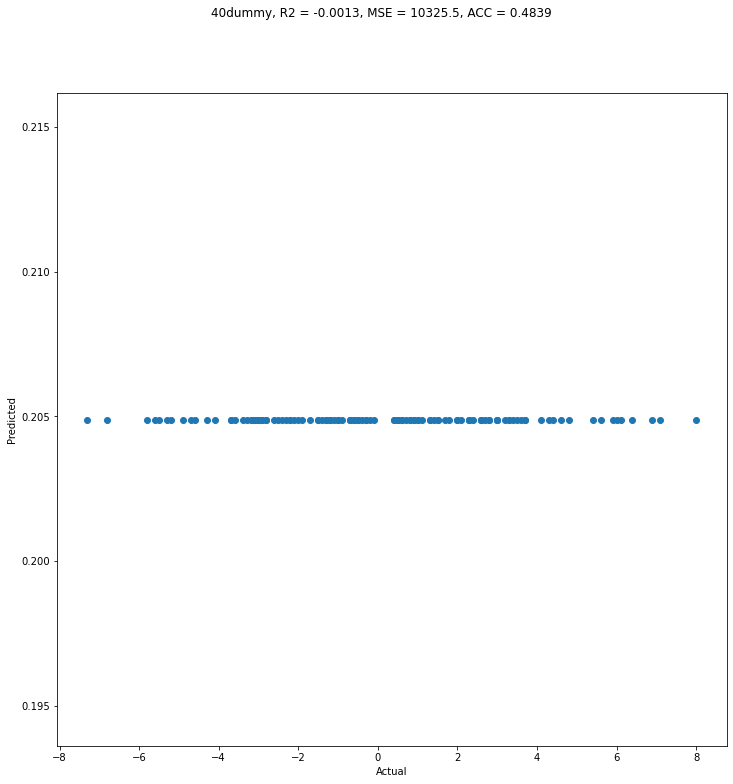

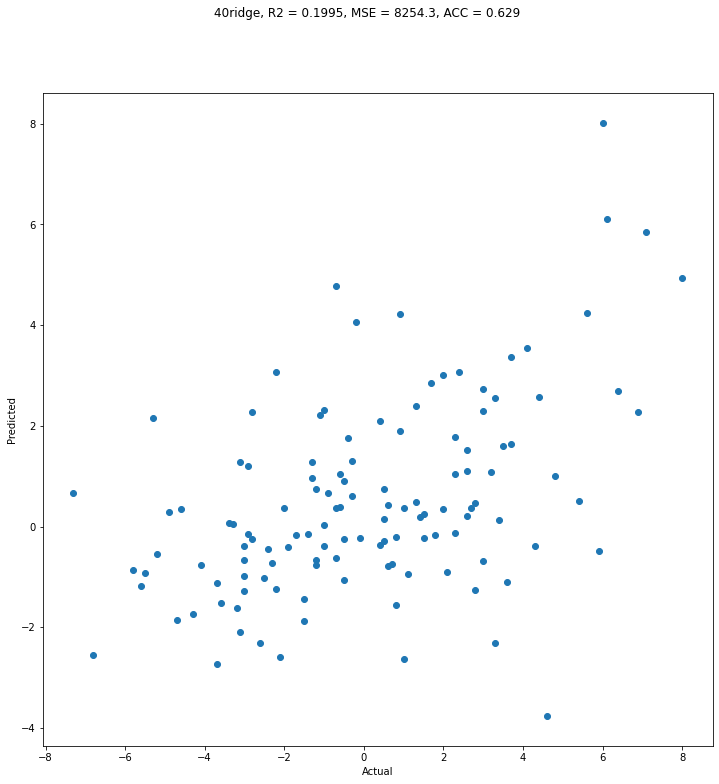

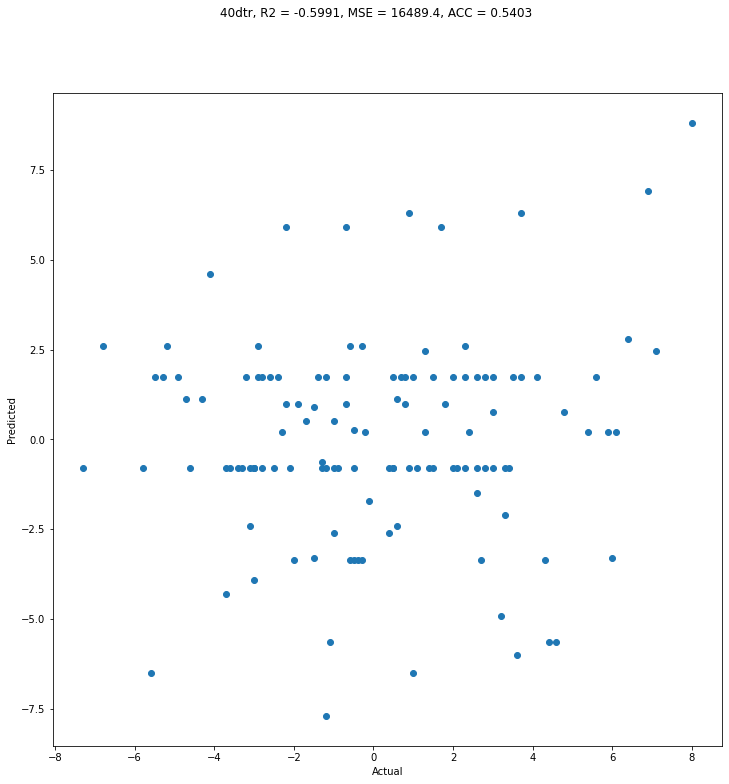

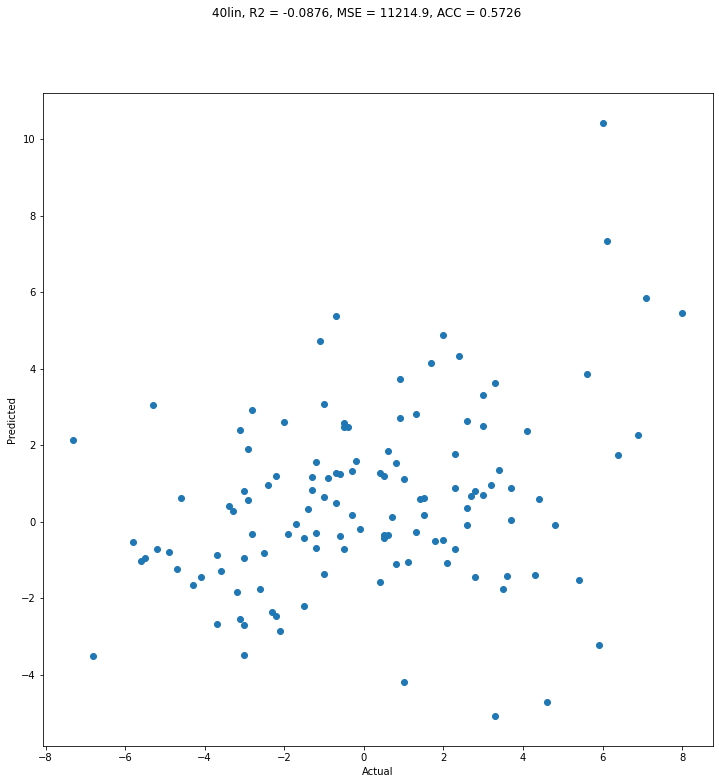

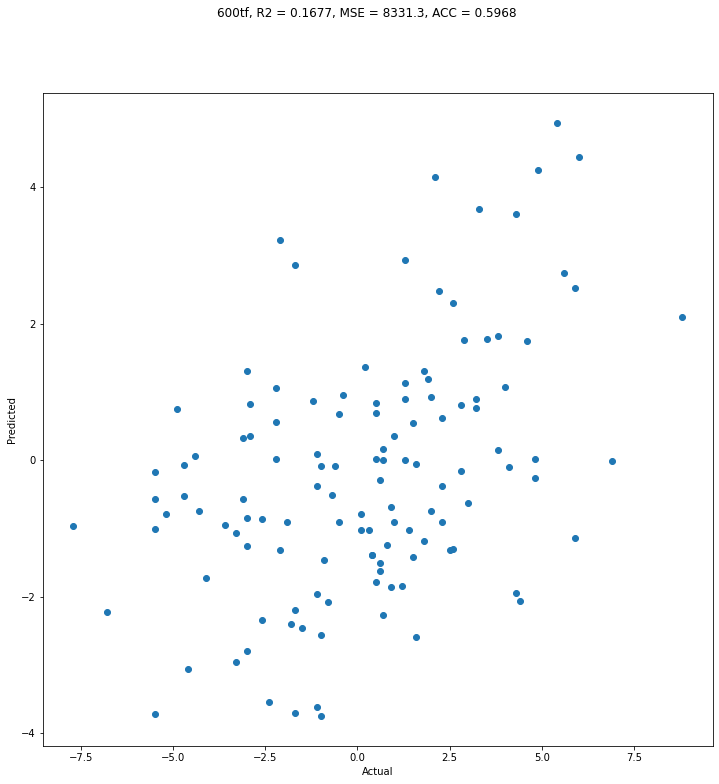

C:\Users\jwesi\AppData\Local\Temp\ipykernel_32640\867298794.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfasd=dfasd.append(pd.DataFrame.from_dict({'Actual':y_values[i],'Pred':preds}))
C:\Users\jwesi\AppData\Local\Temp\ipykernel_32640\867298794.py:11: RuntimeWarning: invalid value encountered in longlong_scalars
  negacc = round(tn/(fn+tn),2)


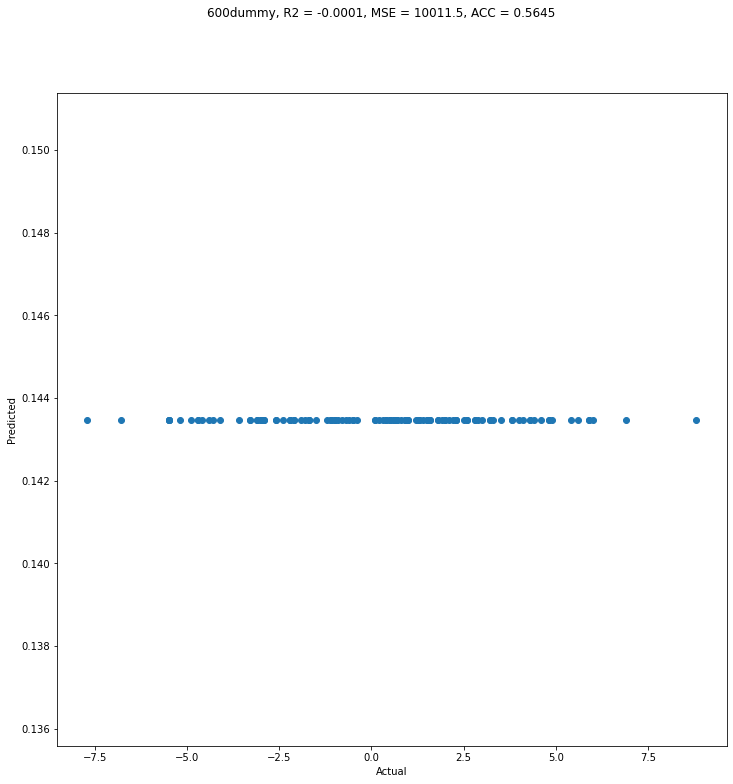

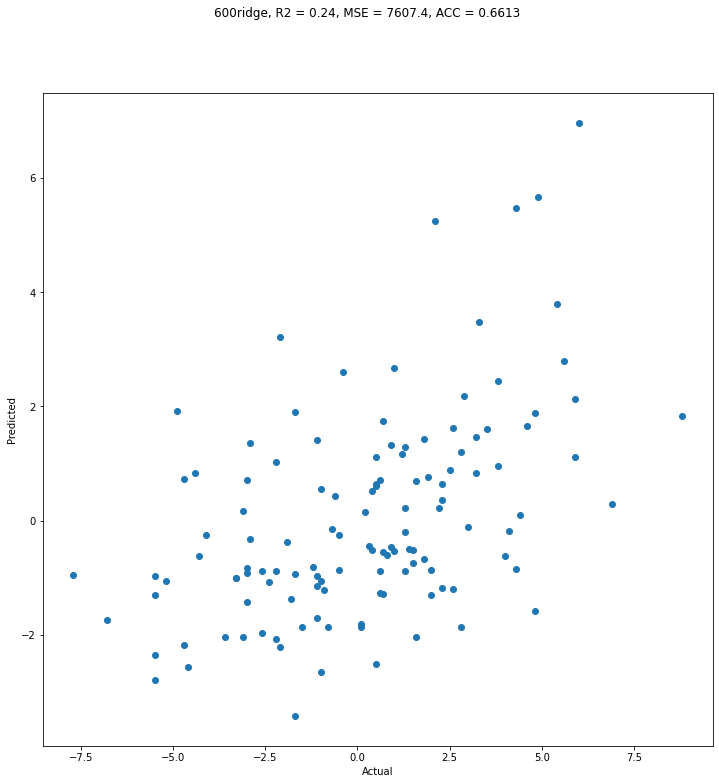

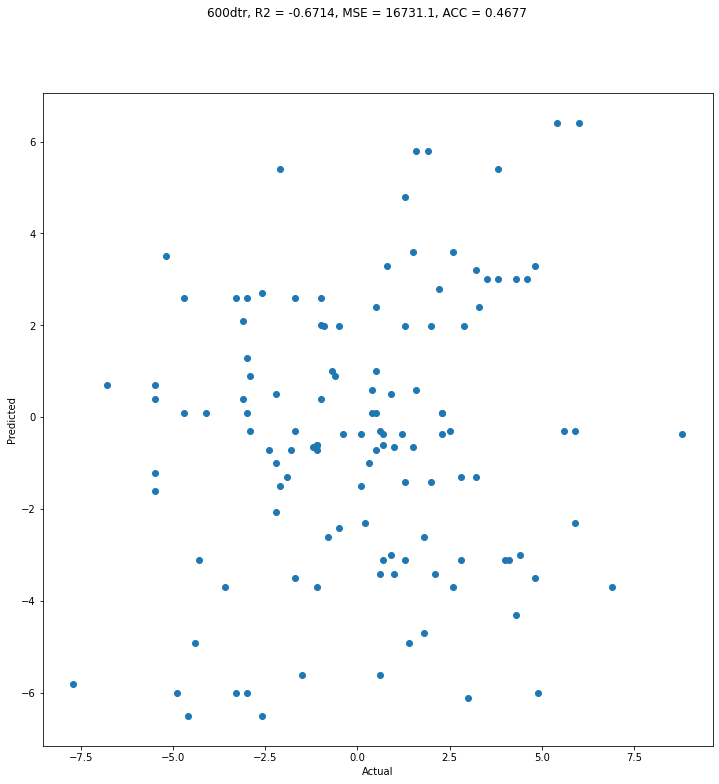

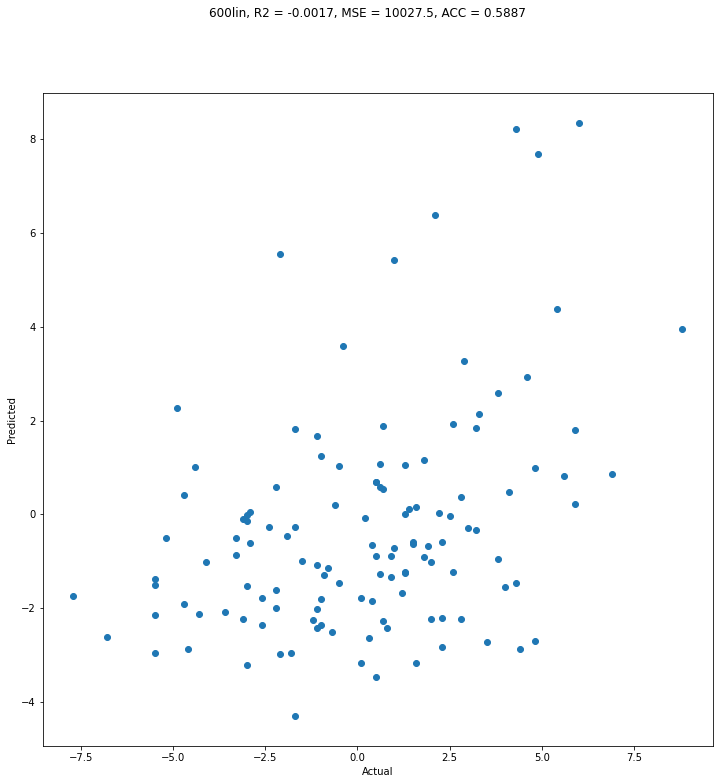

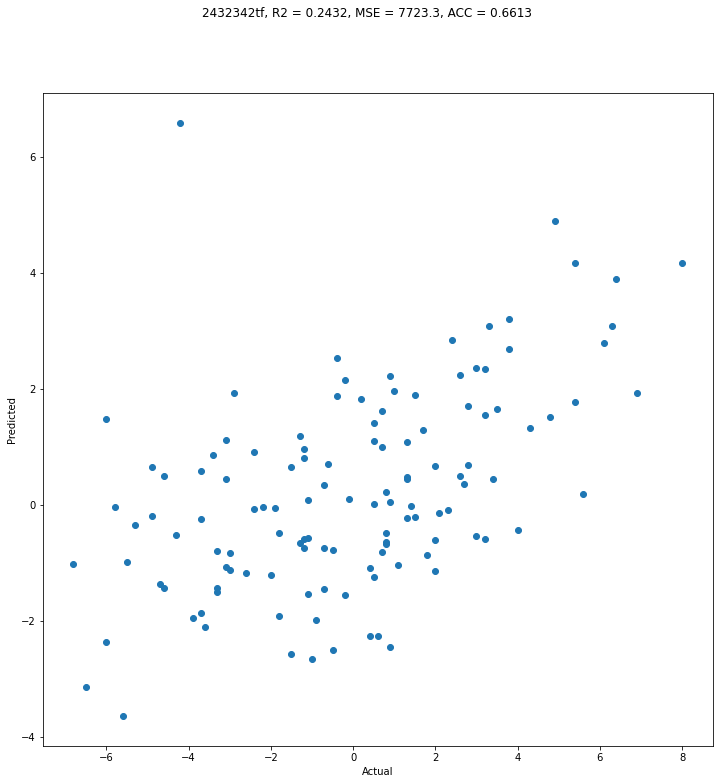

C:\Users\jwesi\AppData\Local\Temp\ipykernel_32640\867298794.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfasd=dfasd.append(pd.DataFrame.from_dict({'Actual':y_values[i],'Pred':preds}))
C:\Users\jwesi\AppData\Local\Temp\ipykernel_32640\867298794.py:11: RuntimeWarning: invalid value encountered in longlong_scalars
  negacc = round(tn/(fn+tn),2)


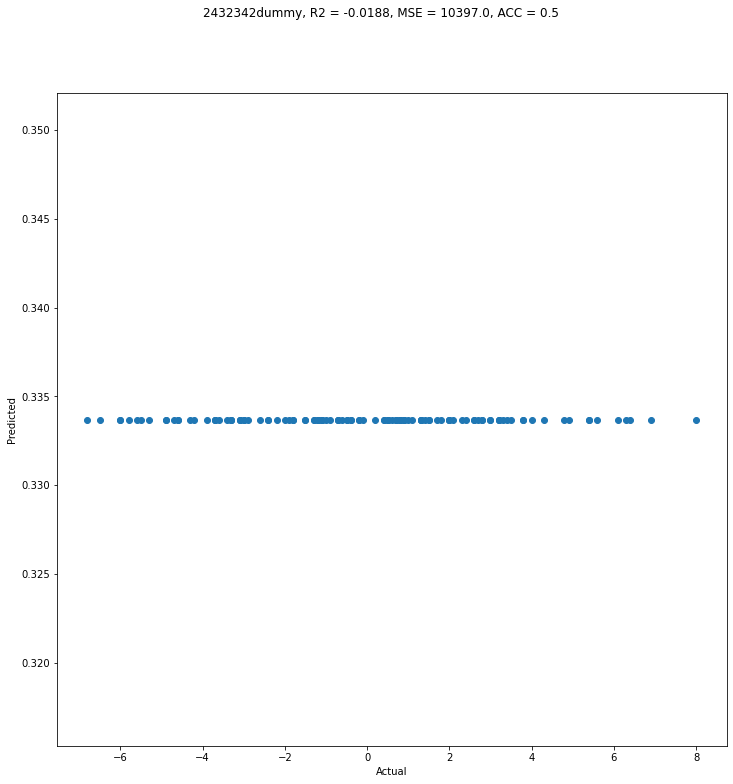

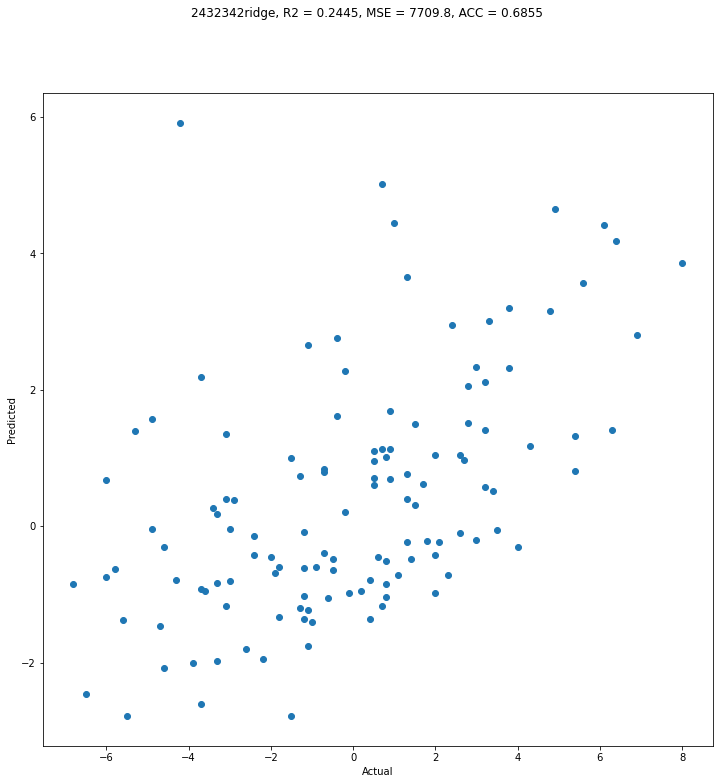

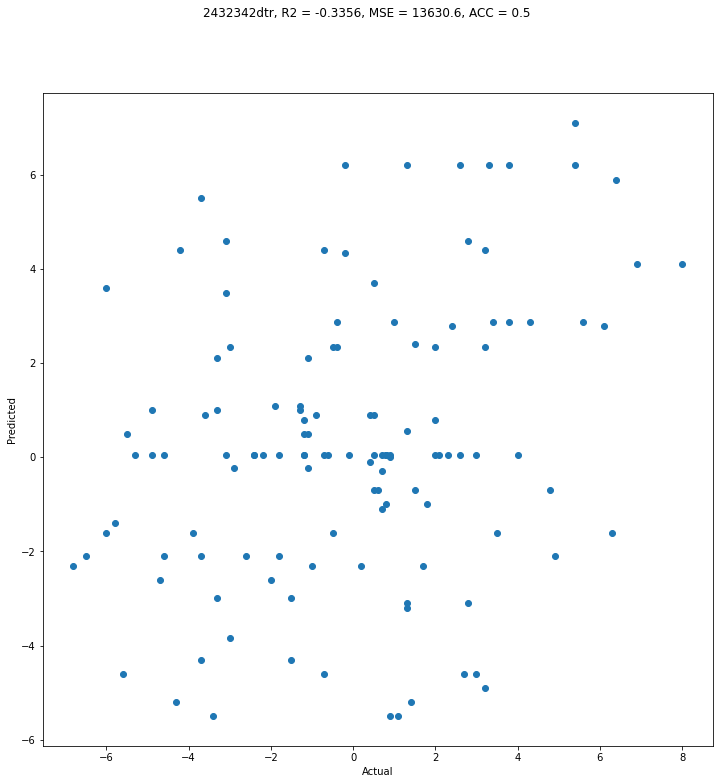

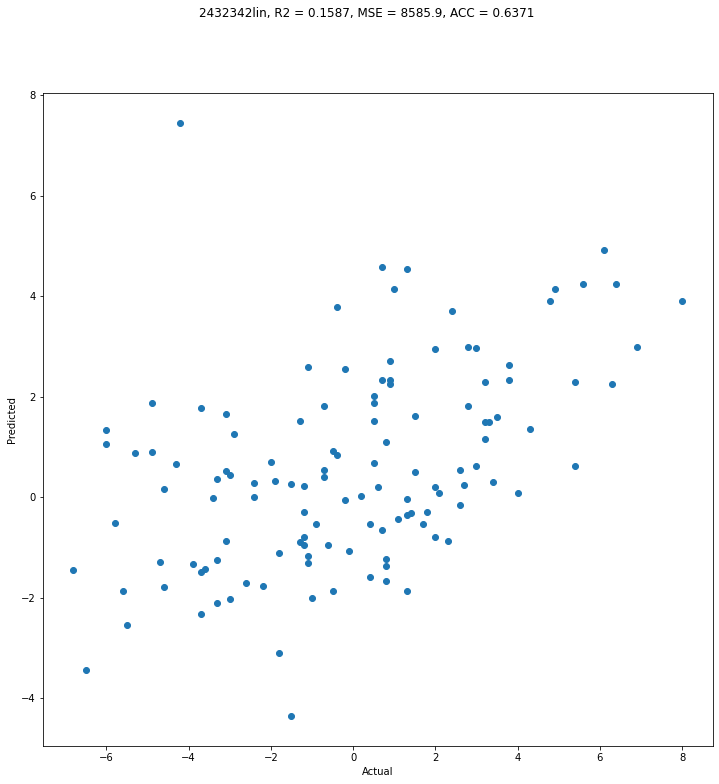

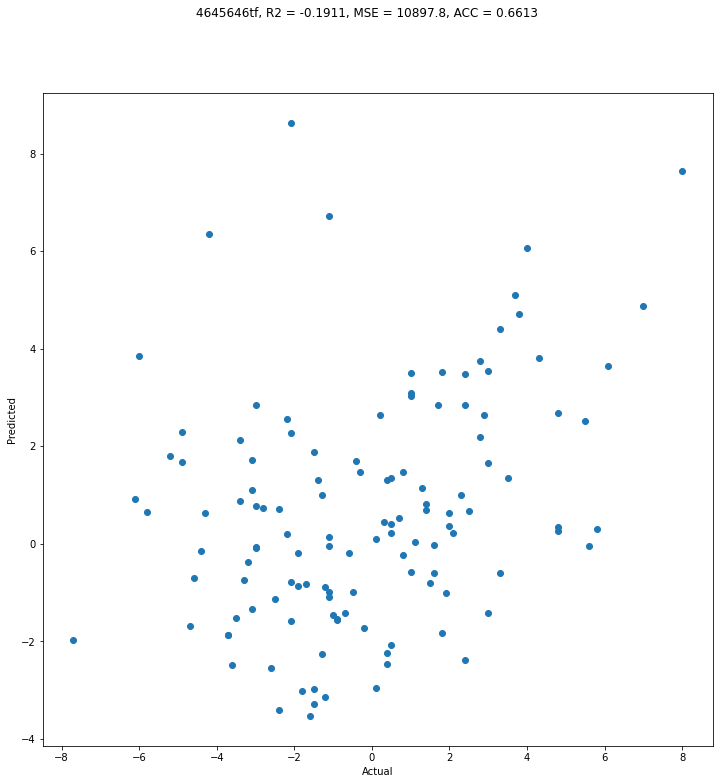

C:\Users\jwesi\AppData\Local\Temp\ipykernel_32640\867298794.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfasd=dfasd.append(pd.DataFrame.from_dict({'Actual':y_values[i],'Pred':preds}))
C:\Users\jwesi\AppData\Local\Temp\ipykernel_32640\867298794.py:11: RuntimeWarning: invalid value encountered in longlong_scalars
  negacc = round(tn/(fn+tn),2)


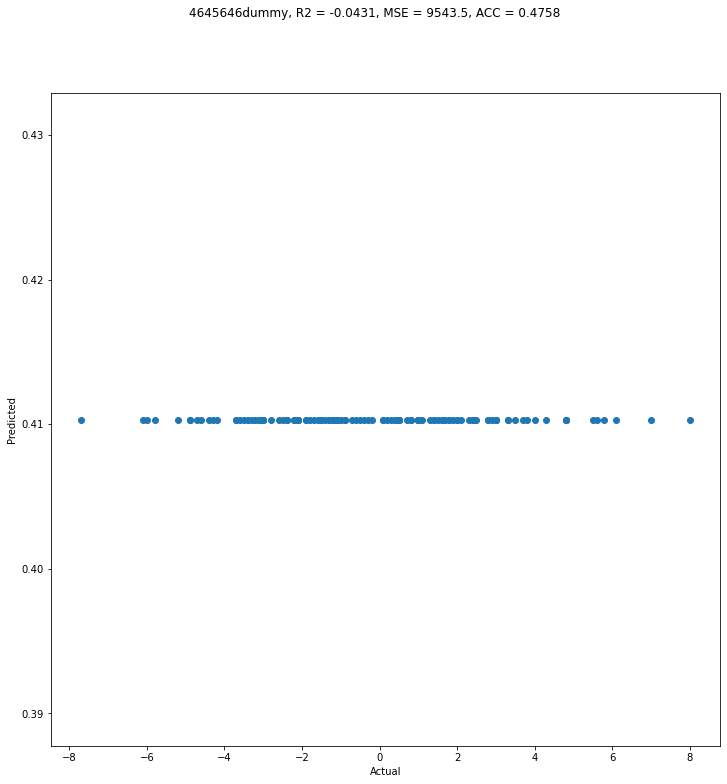

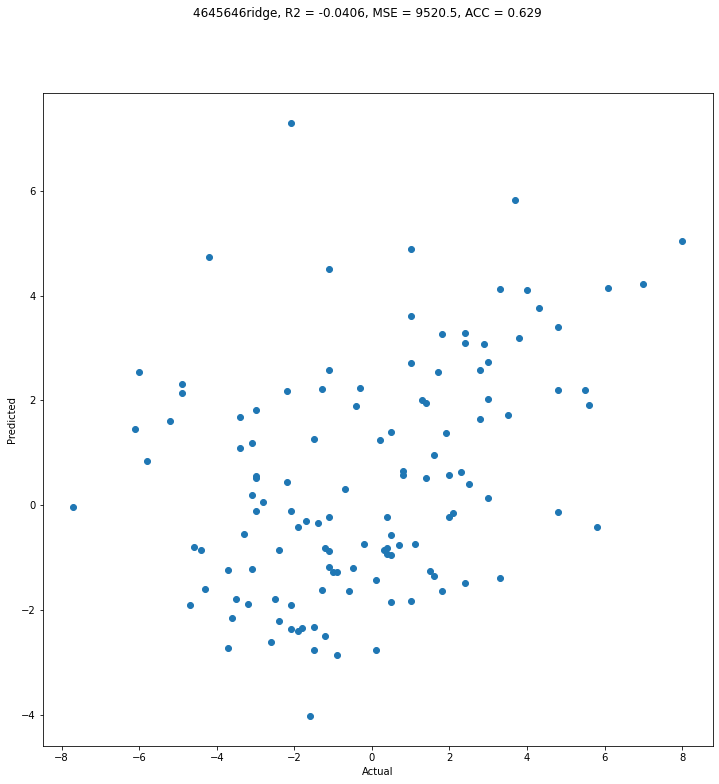

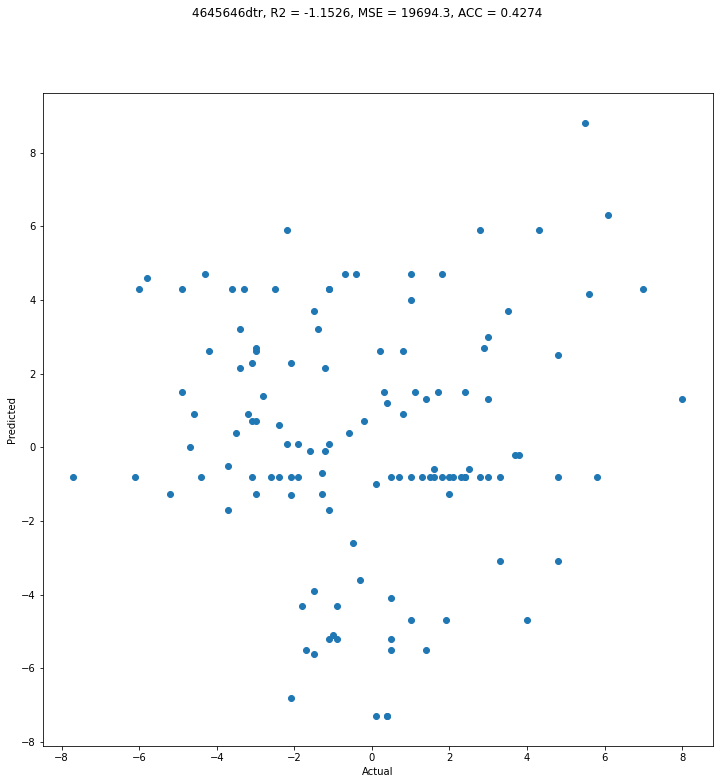

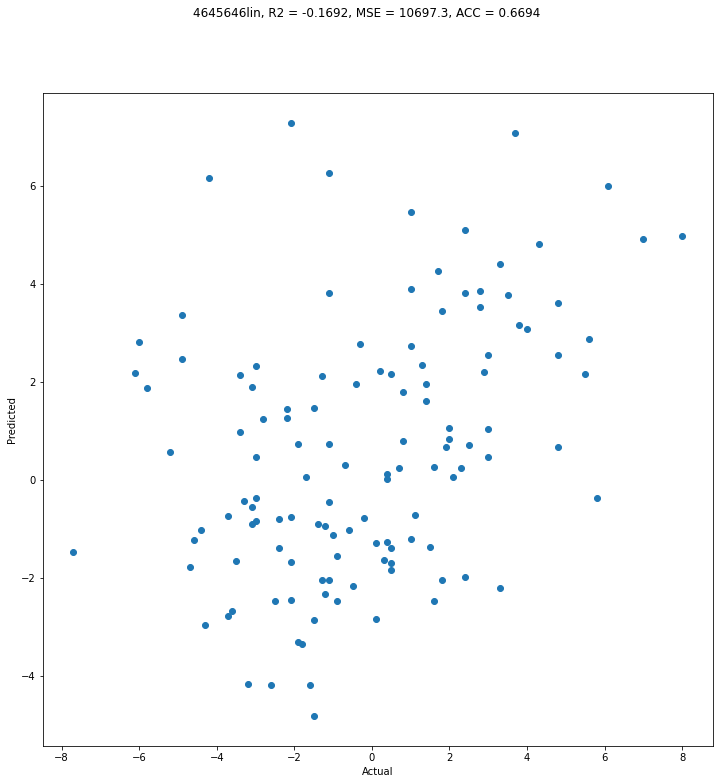

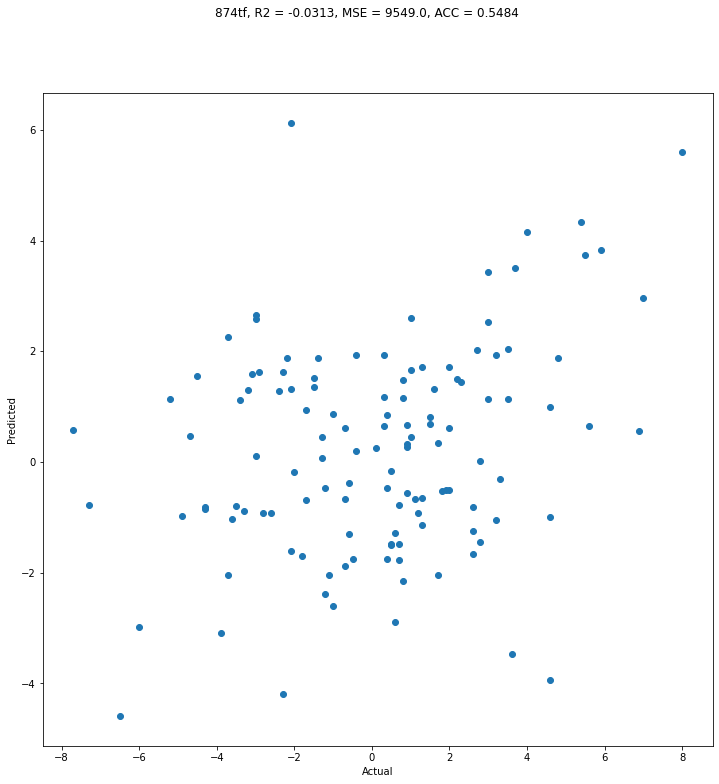

C:\Users\jwesi\AppData\Local\Temp\ipykernel_32640\867298794.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfasd=dfasd.append(pd.DataFrame.from_dict({'Actual':y_values[i],'Pred':preds}))
C:\Users\jwesi\AppData\Local\Temp\ipykernel_32640\867298794.py:11: RuntimeWarning: invalid value encountered in longlong_scalars
  negacc = round(tn/(fn+tn),2)


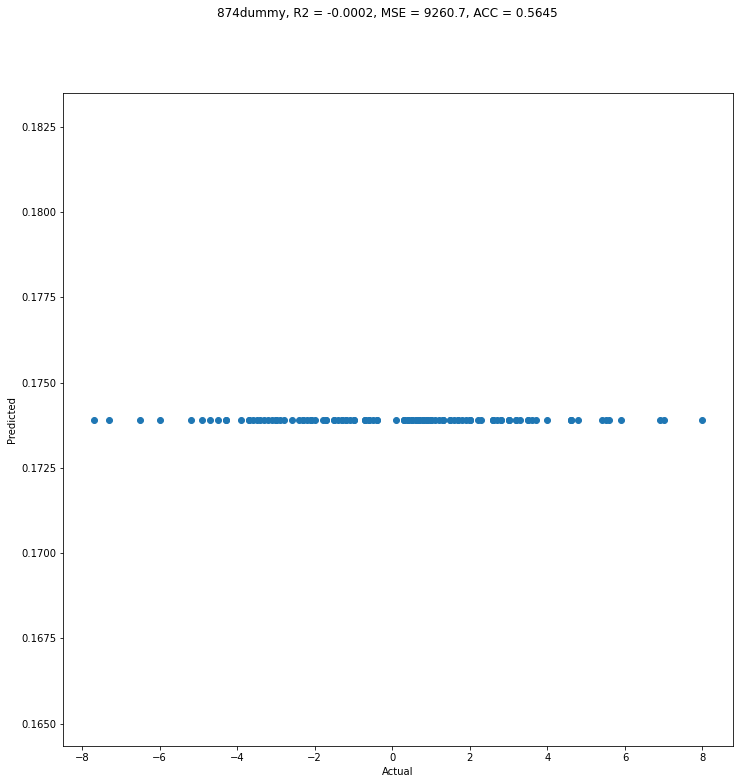

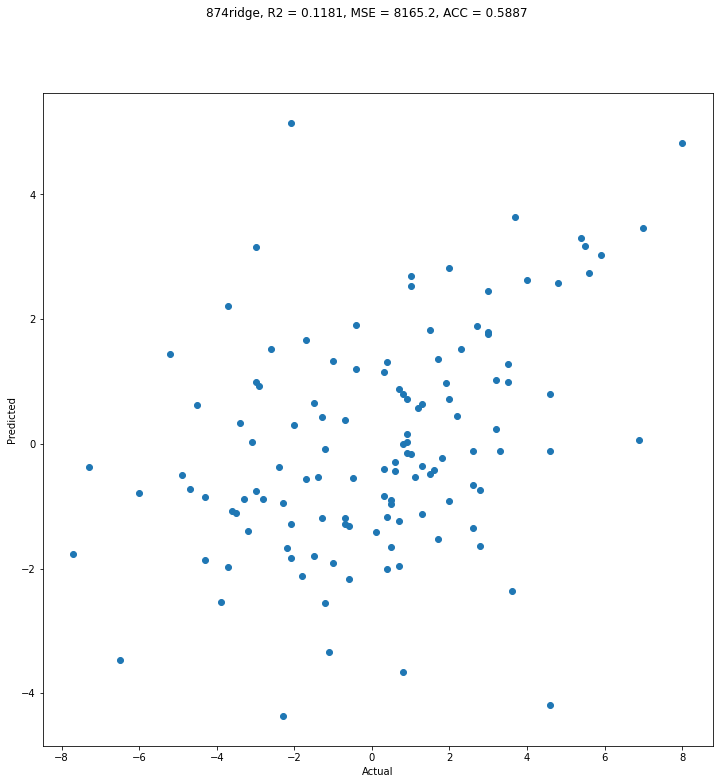

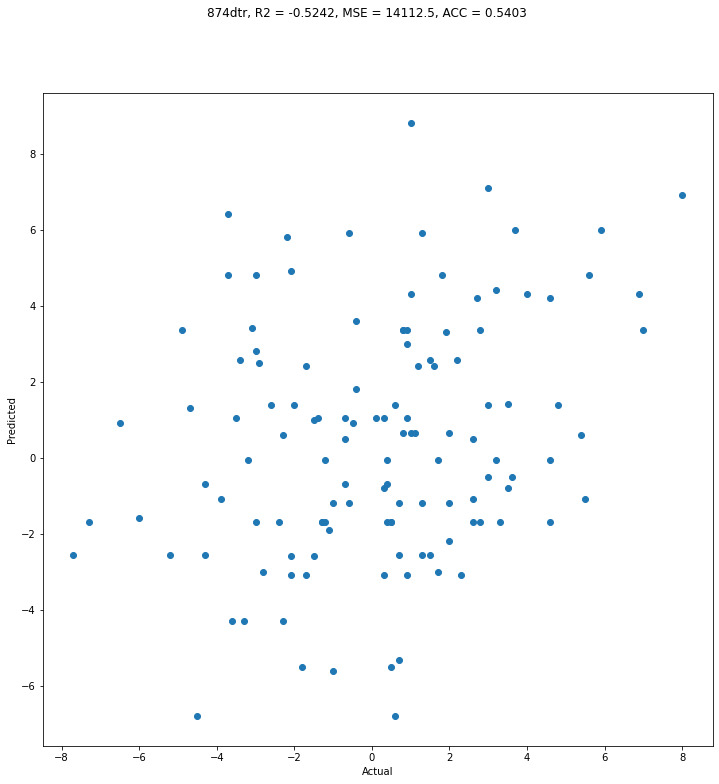

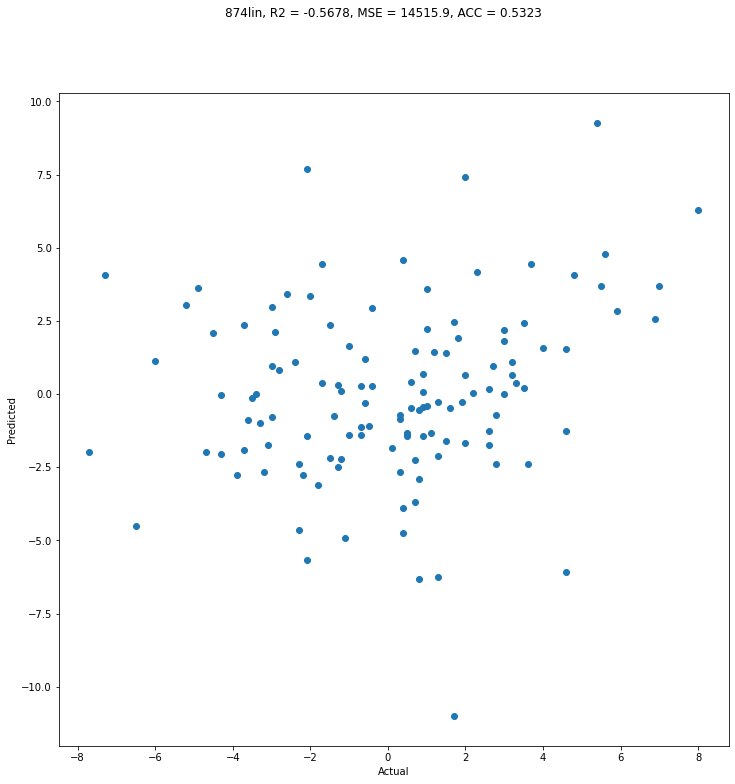

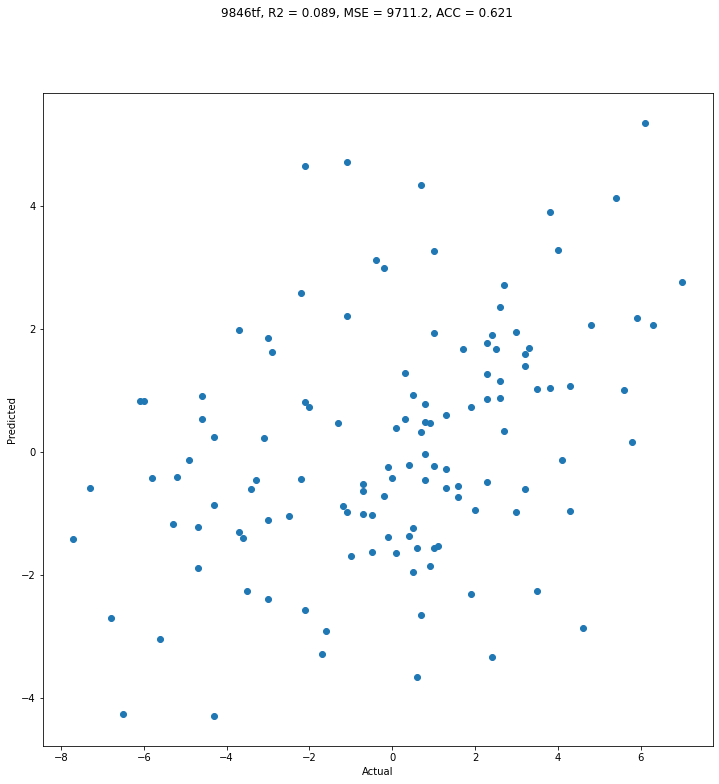

C:\Users\jwesi\AppData\Local\Temp\ipykernel_32640\867298794.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfasd=dfasd.append(pd.DataFrame.from_dict({'Actual':y_values[i],'Pred':preds}))
C:\Users\jwesi\AppData\Local\Temp\ipykernel_32640\867298794.py:11: RuntimeWarning: invalid value encountered in longlong_scalars
  negacc = round(tn/(fn+tn),2)


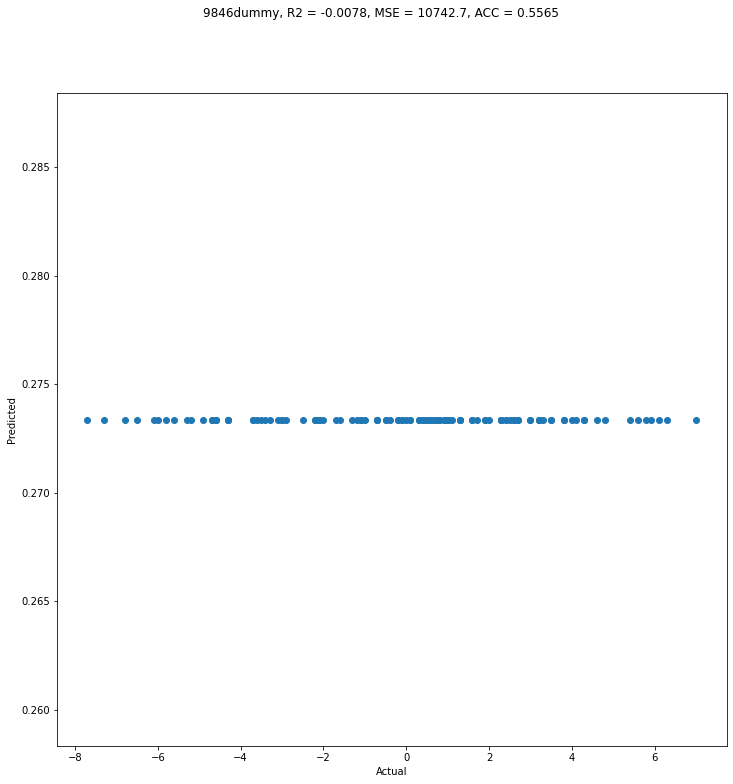

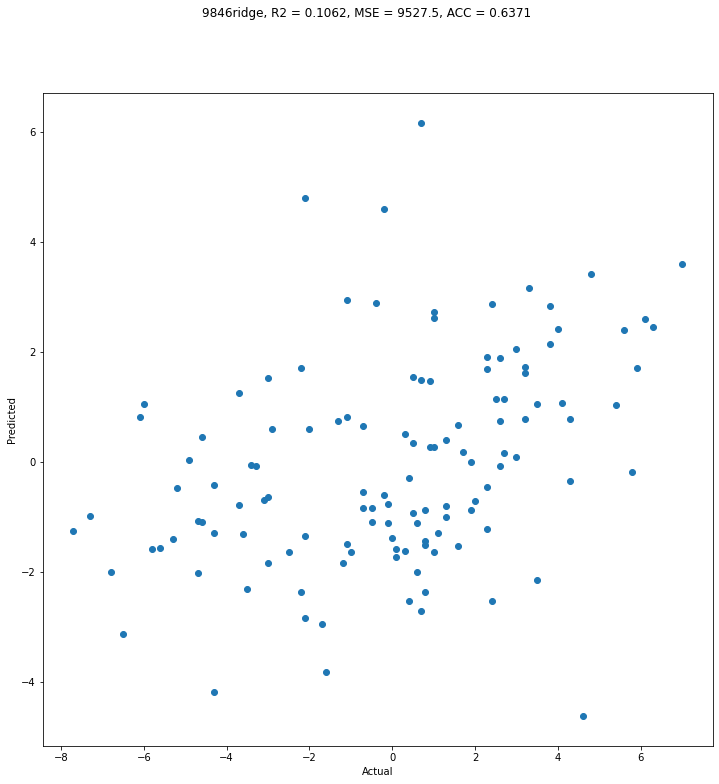

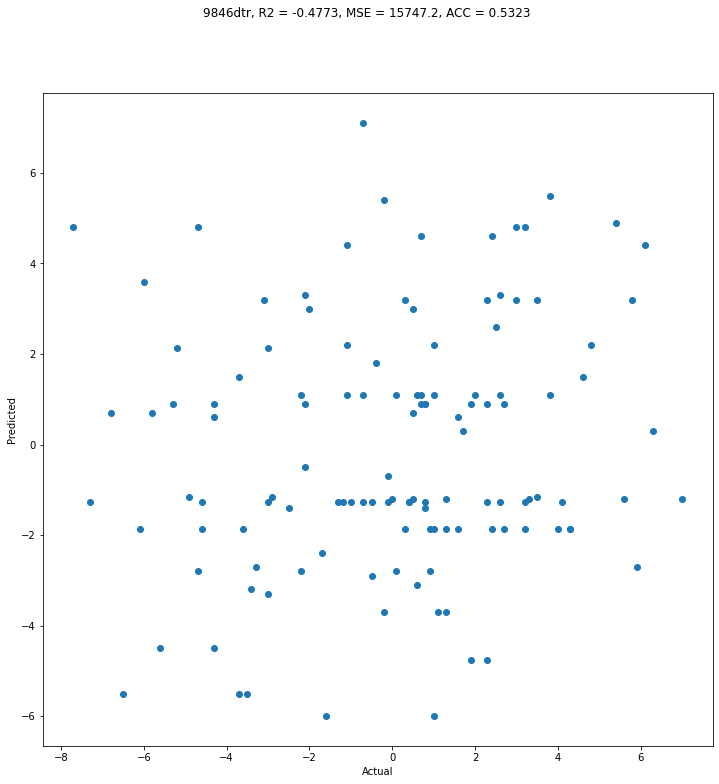

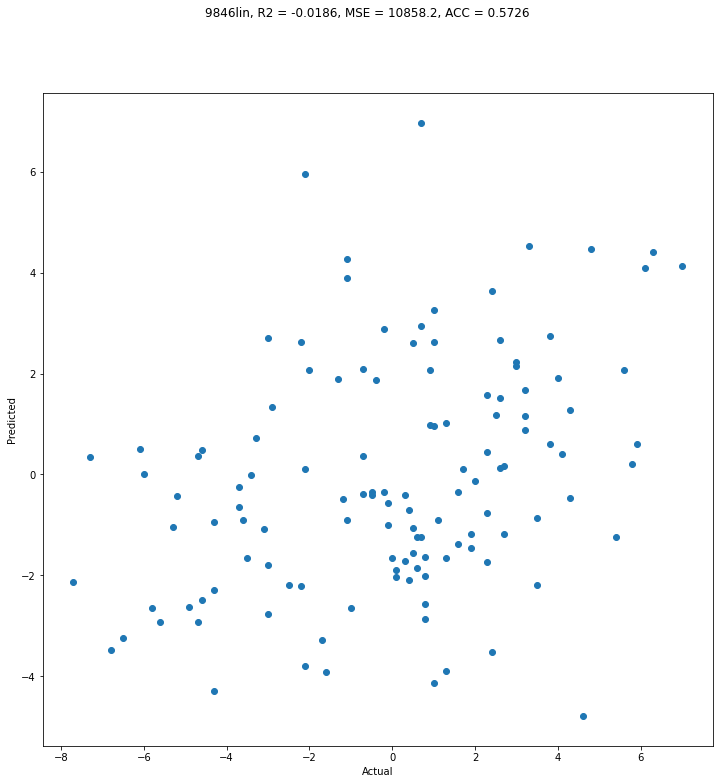

In [55]:
asd = {}
dfasd = pd.DataFrame([[None,None]],columns=['Actual','Pred'])
for i in split_nums:
    for j in ['tf','dummy','ridge','dtr','lin']:
        preds = all_models[str(i)+j].predict(x_values[i]).flatten()
        r2 = r2_score(y_values[i],preds)
        mse = round(1000*mean_squared_error(y_values[i],preds),1)
        acc = round(sum(np.sign(preds)==np.sign(y_values[i]))/len(preds),4)
        tn, fp, fn, tp = confusion_matrix(np.where(y_values[i]>0,1,0),np.where(preds>0,1,0)).ravel()
        posacc = round(tp/(fp+tp),2)
        negacc = round(tn/(fn+tn),2)
#         tp = 
#         fn = 
#         tn = 
        if j+'r2' in asd:
            asd[j+'r2'].append(r2)
            asd[j+'mse'].append(mse)
            asd[j+'acc'].append(acc)
            asd[j+'TN,FP,FN,TP'].append([tn,fp,fn,tp])
            asd[j+'posacc'].append(posacc)
            asd[j+'negacc'].append(negacc)
#             for k in [tn,fp,fn,tp]:
#                 asd[j+'TN,FP,FN,TP'].append(k)
        else:
            asd[j+'r2']=[r2]
            asd[j+'mse']=[mse]
            asd[j+'acc']=[acc]
            asd[j+'TN,FP,FN,TP'] = [[tn,fp,fn,tp]]
            asd[j+'posacc'] = [posacc]
            asd[j+'negacc'] = [negacc]
        plt.figure(figsize=(12,12))
        plt.scatter(y_values[i],preds)
        title = str(i)+j+', R2 = '+str(round(r2,4))+', MSE = '+str(mse)+', ACC = '+ str(acc)
        plt.suptitle(title)
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.show()
        if j == 'tf':
            dfasd=dfasd.append(pd.DataFrame.from_dict({'Actual':y_values[i],'Pred':preds}))
#     plt.title(str(i)+'TF, R2 = '+str(r2_score(y_values[i],all_models[str(i)+'tf'].predict(x_values[i]))))
#     plt.show()
#     plt.scatter(y_values[i],all_models[str(i)+'dummy'].predict(x_values[i]))
#     title(str(i)+'dummy, R2 = '+str(r2_score(y_values[i],all_models[str(i)+'dummy'].predict(x_values[i]))))
#     plt.show()
#     plt.scatter(y_values[i],all_models[str(i)+'ridge'].predict(x_values[i]))
#     title(str(i)+'ridge, R2 = '+str(r2_score(y_values[i],all_models[str(i)+'ridge'].predict(x_values[i]))))
#     plt.show()
#     plt.scatter(y_values[i],all_models[str(i)+'dtr'].predict(x_values[i]))
#     title(str(i)+'dtr, R2 = '+str(r2_score(y_values[i],all_models[str(i)+'dtr'].predict(x_values[i]))))
#     plt.show()

In [60]:
train_features, train_labels, test_features, test_labels = train_test_split_df(predict_plus_minus,'PLUS_MINUS',random_state=i)
normalizer.adapt(train_features)
tf = tf_model(normalizer)
tf.fit(train_features, train_labels, epochs=50, verbose=False)
preds = tf.predict(test_features).flatten()
r2 = r2_score(test_labels,preds)
r2

0.017776580256023133

In [37]:
preds

array([-1.8577988e+00, -2.6611915e+00,  9.1078550e-01, -1.1480203e+00,
        8.0405921e-01, -1.7062328e+00, -8.1062339e-02,  1.6940596e+00,
       -1.5342925e+00, -1.6118822e-01,  8.9414078e-01, -1.4478869e+00,
       -8.2408202e-01, -1.3715017e+00,  1.5412968e-01, -1.6392002e+00,
       -1.1440247e-01,  4.1559038e-01, -2.1113255e+00,  2.2851951e+00,
       -8.7017828e-01,  1.0190737e-01,  2.1997266e+00,  3.4777124e+00,
       -1.4027171e+00,  6.3700497e-01,  2.8098962e+00,  3.9698100e+00,
       -5.7889204e-03, -1.4668515e+00,  1.6820538e+00, -5.0669253e-01,
        4.8783439e-01,  2.3769674e+00, -5.6398672e-01, -1.0517910e+00,
       -2.2780386e-01, -1.5596030e+00,  9.2430574e-01, -8.0058056e-01,
       -3.6458263e+00,  1.7181518e+00, -4.9307597e-01,  1.1107609e+00,
        6.9333762e-01,  4.7904438e-01, -2.4032397e+00,  4.8684841e-01,
        4.0166733e-01,  1.5006902e+00,  1.8567834e+00,  8.1948328e-01,
        1.6326389e+00, -6.1295336e-01, -1.3052535e+00,  3.1567615e-01,
      